# Quantum Machine Learning for Network Intrusion Detection
This notebook demonstrates the use of quantum machine learning for the task of network intrusion detection. We use a subset of the KDD Cup 1999 dataset and employ a quantum kernel-based support vector machine to classify normal and attack network traffic. The goal is to explore the application of quantum machine learning algorithms to real-world problems and understand the workflow, from data preprocessing to model evaluation.



## Installation of Required Packages
To work with quantum machine learning, we need several Qiskit components. Below are the necessary installations:


In [5]:
!pip install qiskit
!pip install qiskit-Aer
!pip install qiskit-ibm-runtime
!pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 9.6 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=118277 sha256=53e17efb798fed5beb2b4971365a57a1ab3572f8ec39dc03a341b86989f8204c
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


## Import Libraries
We need various libraries for data manipulation, visualization, classical machine learning, and quantum computations. We use standard Python libraries such as NumPy and Pandas, as well as Qiskit for quantum operations.


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from qiskit_algorithms.utils import algorithm_globals

from sklearn.svm import SVC

## Data Preparation
### Set Random Seed
Setting a random seed is crucial for ensuring that the results of our code are reproducible.


In [76]:
algorithm_globals.random_seed = 42

### Load Dataset
We use a subset (10%) of the KDD Cup 1999 dataset, which is widely used for network intrusion detection research. It contains various features extracted from network traffic, labeled as either 'normal' or as specific types of attacks.


In [77]:
data_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'

Define column names corresponding to the features of the KDD dataset, which includes metrics such as protocol type, number of bytes sent, etc.

In [78]:
column_names = [
    'duration', 
    'protocol_type', 
    'service', 
    'flag', 
    'src_bytes', 
    'dst_bytes', 
    'land', 
    'wrong_fragment',
    'urgent', 
    'hot', 
    'num_failed_logins', 
    'logged_in', 
    'num_compromised', 
    'root_shell',
    'su_attempted', 
    'num_root', 
    'num_file_creations', 
    'num_shells', 
    'num_access_files',
    'num_outbound_cmds', 
    'is_host_login', 
    'is_guest_login', 
    'count', 
    'srv_count', 
    'serror_rate',
    'srv_serror_rate', 
    'rerror_rate', 
    'srv_rerror_rate', 
    'same_srv_rate', 
    'diff_srv_rate',
    'srv_diff_host_rate', 
    'dst_host_count', 
    'dst_host_srv_count', 
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 
    'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 
    'label'
]

Load the dataset and examine its shape to ensure it is loaded correctly.


In [79]:
print("Loading dataset...")
data = pd.read_csv(data_url, names=column_names)
print("Dataset loaded.")
print(f"Dataset shape: {data.shape}")

Loading dataset...
Dataset loaded.
Dataset shape: (494021, 42)


### Display Initial Data
To understand the dataset better, display the first five rows of data.


In [80]:
print("\nFirst five rows of the dataset:")
print(data.head())


First five rows of the dataset:
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0       

### Sample and Process Data
For faster computation, randomly sample 1000 rows from the dataset. This subset will be used to train the model.
- Convert the labels to binary: `0` represents 'normal' traffic and `1` represents any type of attack.


In [81]:
data_sample = data.sample(n=1000, random_state=42)
data_sample['label'] = data_sample['label'].apply(lambda x: 0 if x == 'normal.' else 1)
print(f"\nSampled dataset shape: {data_sample.shape}")


Sampled dataset shape: (1000, 42)


### Encode Categorical Features
Convert categorical features (`protocol_type`, `service`, and `flag`) to numerical values using `LabelEncoder`.


In [14]:
categorical_features = ['protocol_type', 'service', 'flag']
for col in categorical_features:
    le = LabelEncoder()
    data_sample[col] = le.fit_transform(data_sample[col])

### Select Features for Model
Select a subset of features, including both categorical and numerical values, for training the model.


In [15]:
features = ['duration', 'protocol_type', 'src_bytes', 'dst_bytes', 'count']
X = data_sample[features]
y = data_sample['label']

### Scale Features
Normalize the feature set to a range of `[0, 1]` using `MinMaxScaler`. Scaling helps in ensuring that all features have equal weightage during training.


In [16]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Split Dataset
Split the scaled dataset into training and test sets. This step helps in evaluating the performance of the model on unseen data.


In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 800 samples
Testing set size: 200 samples


## Quantum Feature Mapping
### Define Quantum Feature Map
Use `ZZFeatureMap` with full entanglement to encode classical data into quantum states. The feature map represents the interaction between features in a quantum state.


In [19]:
num_qubits = X_train.shape[1]
feature_map = ZZFeatureMap(
    feature_dimension=num_qubits, reps=2, entanglement='full'
)

## Quantum Simulation Setup
### Initialize Quantum Simulator
We use `AerSimulator` to simulate quantum computations without needing access to a physical quantum computer.


In [31]:
simulator = AerSimulator()

### Set Up Quantum Kernel
Use `StatevectorSampler` and `FidelityStatevectorKernel` to compute the quantum kernel. The kernel measures the similarity of the input vectors in the quantum feature space.


In [84]:
backend = simulator
sampler = StatevectorSampler()

quantum_kernel = FidelityStatevectorKernel(feature_map=feature_map)

## Compute Quantum Kernel Matrices
### Compute Training and Test Kernels
The quantum kernel matrices represent pairwise similarities in the quantum feature space, computed for both the training and testing datasets.


In [85]:
print("\nComputing quantum kernel matrices...")
print("Computing training set...")
kernel_matrix_train = quantum_kernel.evaluate(x_vec=X_train)
print("Computing test set...")
kernel_matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
print("Done")


Computing quantum kernel matrices...
Computing training set...
Computing test set...


## Train Classical SVM Using Quantum Kernel
### Train Support Vector Classifier
The `SVC` classifier is trained using the precomputed quantum kernel. This combines classical machine learning (SVM) with quantum-enhanced feature mapping.


In [86]:
print("Training the Support Vector Classifier with quantum kernel...")
svc = SVC(kernel='precomputed')
svc.fit(kernel_matrix_train, y_train)
print("Done")

Training the Support Vector Classifier with quantum kernel...
Done


### Make Predictions on Test Set
Use the trained SVM model to make predictions on the test set.


In [87]:
print("Making predictions on the test set...")
y_pred = svc.predict(kernel_matrix_test)
print("Done")

Making predictions on the test set...
Done


### Display Classification Report for RBF Kernel
Display the classification report for the SVM using the RBF kernel.


In [99]:
print("Classification Report for RBF Kernel:")
print(classification_report(y_test, y_pred_rbf))

Classification Report for RBF Kernel:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.99      0.99       160

    accuracy                           0.99       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.99      0.99       200



### Display Classification Report
A classification report provides detailed evaluation metrics such as precision, recall, and F1-score for both classes ('Normal' and 'Attack').


In [100]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        40
           1       0.99      0.99      0.99       160

    accuracy                           0.98       200
   macro avg       0.97      0.98      0.98       200
weighted avg       0.99      0.98      0.99       200



### Plot Confusion Matrix
A confusion matrix provides a summary of prediction results on the test set, indicating the number of true positives, false positives, true negatives, and false negatives.


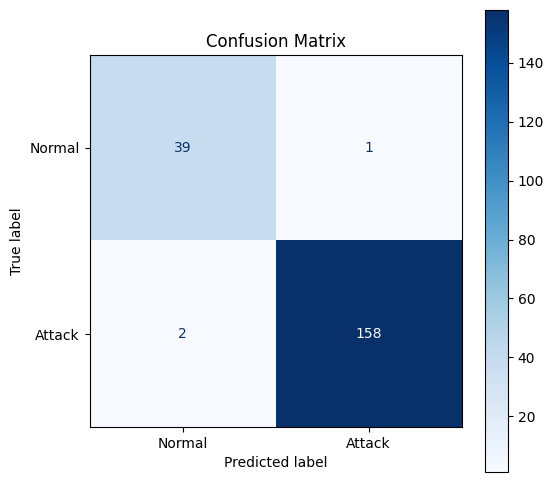

In [92]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Summary
In this notebook, we explored how quantum machine learning can be applied to a real-world problem, specifically network intrusion detection. We preprocessed the dataset, used a quantum kernel to create feature maps, and trained a support vector classifier to detect attacks. 